# Generalized Additive Model (GAM)

Maintainer: Zhaohu(Jonathan) Fan.Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.

## Table of Contents

1. [Generalized Additive Model](#1-generalized-additive-model)  
   1.1 [GAM on Boston Housing Dataset](#11-gam-on-boston-housing-dataset)  
   1.2 [GAM on Credit Card Default Data](#12-gam-on-credit-card-default-data)  
   &nbsp;&nbsp;&nbsp;&nbsp;1.2.1 [In-sample Fit Performance](#121-in-sample-fit-performance)  
   &nbsp;&nbsp;&nbsp;&nbsp;1.2.2 [Out-of-sample Fit Performance](#122-out-of-sample-fit-performance)  
   1.3 [GAM Using the “Motorcycle” Dataset](#13-gam-using-the-motorcycle-dataset)  


#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/1iJrwRadMw5UKF0n3iaWzyQSVJg0koPxw?usp=sharing)*
#### *Useful information about [Generalized Additive Model in R](https://yanyudm.github.io/Data-Mining-R/lecture/8.B_GAM.html)*





# 1. Generalized Additive Model (GAM)

In **Python (Google Colab)**, GAMs are most commonly fit using one of these approaches:

- **`pyGAM`** (a dedicated GAM library): provides GAMs with spline smoothers and automatic smoothing parameter selection.
- **`statsmodels`** (GAM module): supports GAM-style models using spline bases (the workflow is slightly more manual than `pyGAM`).

While these tools implement the same high-level idea—modeling a response as the sum of smooth functions of predictors—their default smoothers, tuning procedures, and outputs can differ. As a result, you may see **slightly different results** even when using the same model structure on the same dataset.

## 1.1 GAM on Boston Housing Dataset


In [3]:
# ============================================================
# 1. Setup
# ============================================================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

RANDOM_STATE = 123


In [5]:
import importlib, sys

if importlib.util.find_spec("pygam") is None:
    !pip -q install pygam

from pygam import LinearGAM, s, f


In [7]:
# ------------------------------------------------------------
# 0) Load Boston Housing data (your exact code)
# ------------------------------------------------------------
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

boston = pd.DataFrame(
    data,
    columns=["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT"]
)
boston["MEDV"] = target

boston.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [9]:
# ------------------------------------------------------------
# 1) Train/test split (90/10, consistent with your earlier labs)
# ------------------------------------------------------------
np.random.seed(1234)

X = boston.drop(columns=["MEDV"])
y = boston["MEDV"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (354, 13) Test: (152, 13)


In [11]:
# ------------------------------------------------------------
# 2) Install and import pyGAM (GAM library)
# ------------------------------------------------------------
# If running in Colab, uncomment:
# !pip -q install pygam

from pygam import LinearGAM, s, f


In [13]:
# ------------------------------------------------------------
# 3) Fit a GAM
# Notes:
# - Use smooth terms s() for continuous predictors
# - Use factor term f() for CHAS (0/1 indicator)
# - pyGAM expects numpy arrays
# ------------------------------------------------------------

feature_names = list(X_train.columns)
col_idx = {name: i for i, name in enumerate(feature_names)}

# Build the model terms:
# All continuous predictors as smooth terms, CHAS as factor term.
terms = (
    s(col_idx["CRIM"]) +
    s(col_idx["ZN"]) +
    s(col_idx["INDUS"]) +
    f(col_idx["CHAS"]) +
    s(col_idx["NOX"]) +
    s(col_idx["RM"]) +
    s(col_idx["AGE"]) +
    s(col_idx["DIS"]) +
    s(col_idx["RAD"]) +
    s(col_idx["TAX"]) +
    s(col_idx["PTRATIO"]) +
    s(col_idx["B"]) +
    s(col_idx["LSTAT"])
)

gam = LinearGAM(terms)

# Fit with automatic smoothing parameter selection (grid search)
gam.gridsearch(X_train.to_numpy(), y_train.to_numpy())

print(gam.summary())


100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:050:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     69.6382
Link Function:                     IdentityLink Log Likelihood:                                  -846.2151
Number of Samples:                          354 AIC:                                             1833.7067
                                                AICc:                                            1869.5501
                                                GCV:                                               13.0001
                                                Scale:                                               2.915
                                                Pseudo R-Squared:                                   0.9204
Feature Function                  Lam

/var/folders/nl/f_x36gk55bjgcqv4y5k__plw0000gq/T/ipykernel_81869/2845929758.py:35: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [15]:
# ------------------------------------------------------------
# 4) Prediction + Test MSE (5 decimal places)
# ------------------------------------------------------------
y_pred = gam.predict(X_test.to_numpy())
test_mse = mean_squared_error(y_test, y_pred)

print(f"GAM Test MSE: {test_mse:.5f}")


GAM Test MSE: 17.48103


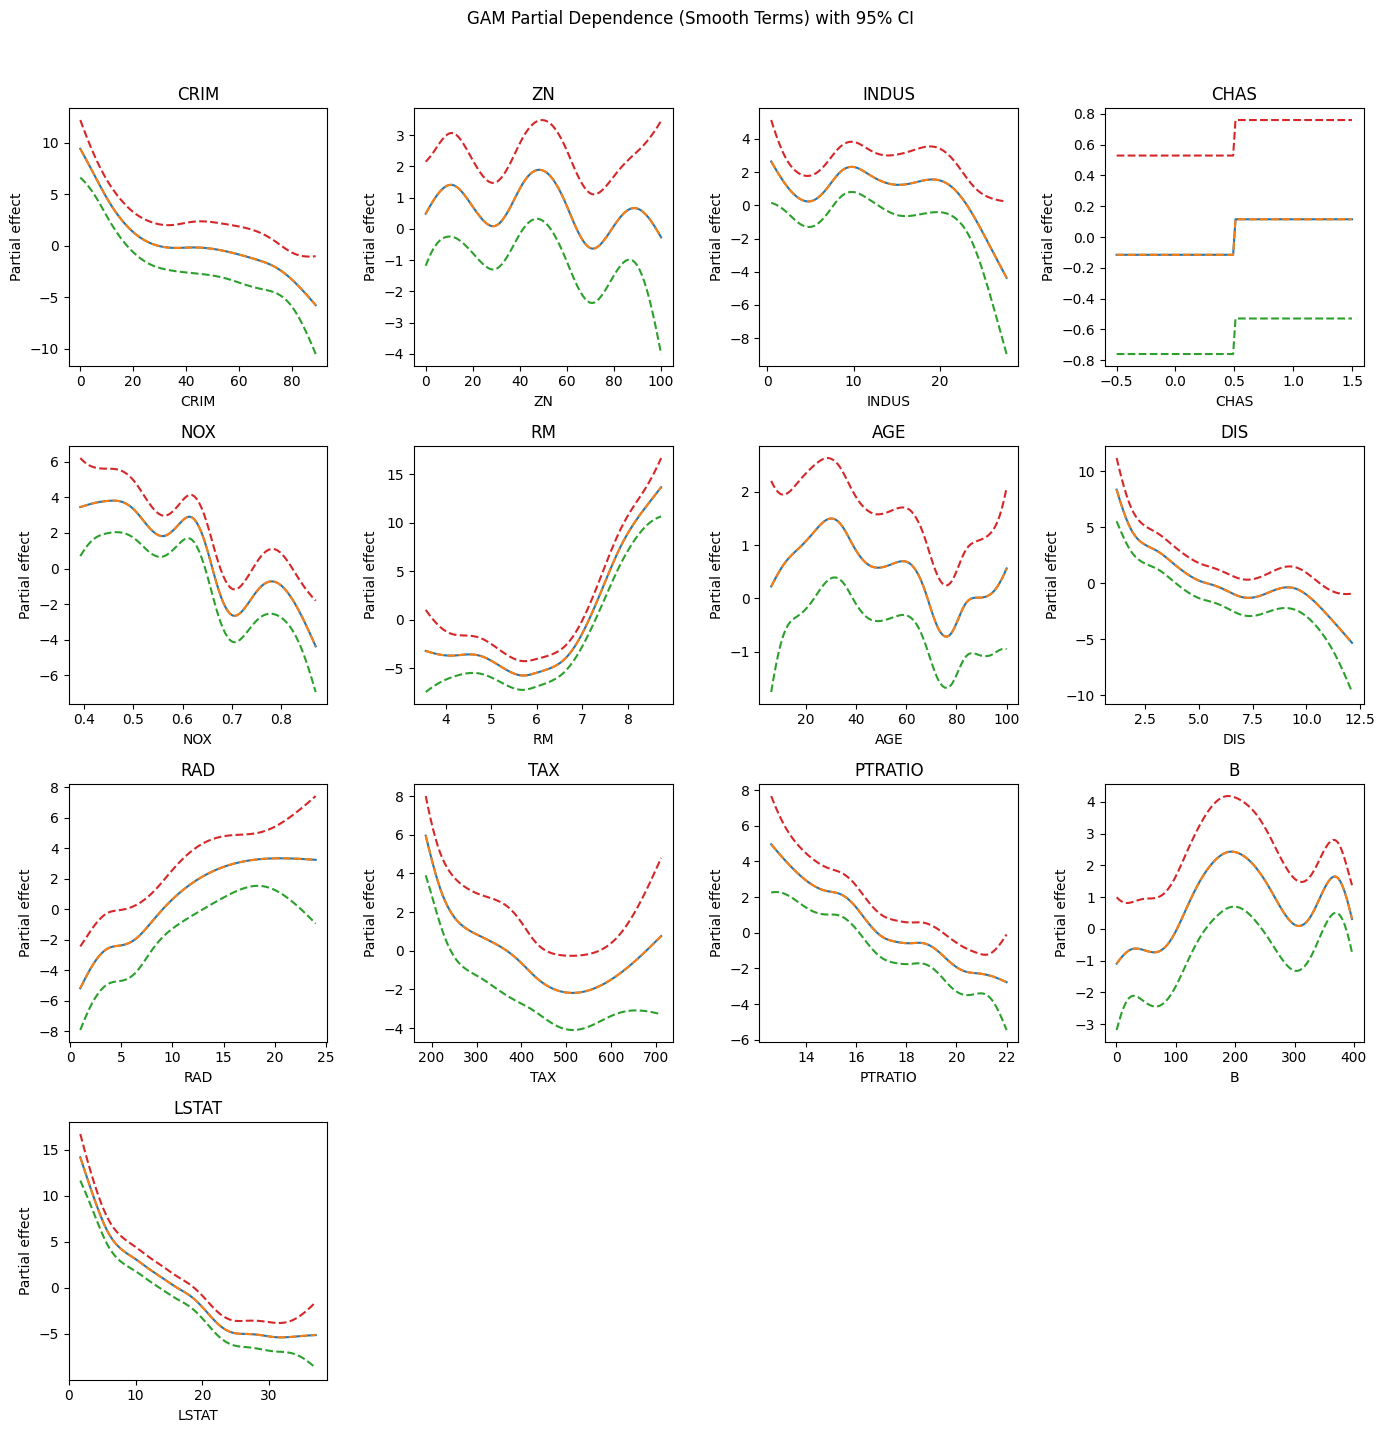

In [17]:
# ------------------------------------------------------------
# Partial Dependence Plots in a 3x4 grid (Boston GAM, pyGAM)
# - Plots all smooth terms s() (12 continuous predictors)
# - Skips intercept and factor term f(CHAS)
# - Adds 95% CI (dashed lines)
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

def plot_pdp_grid_4x4(gam_model, feature_names, ci_width=0.95):
    # Collect (term_id, feature_index, feature_name) for smooth terms only
    smooth_terms = []
    for term_id, term in enumerate(gam_model.terms):
        if getattr(term, "isintercept", False):
            continue
        # Smooth terms have spline metadata; factor terms generally don't
        if not hasattr(term, "spline_order"):
            continue
        feat_idx = term.feature
        smooth_terms.append((term_id, feat_idx, feature_names[feat_idx]))

    # Create 4x4 layout (expecting  smooth terms for Boston if CHAS is factor)
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 14))
    axes = axes.ravel()

    # Plot  smooth terms
    for ax_i in range(nrows * ncols):
        ax = axes[ax_i]

        if ax_i >= len(smooth_terms):
            ax.axis("off")
            continue

        term_id, feat_idx, feat_name = smooth_terms[ax_i]

        XX = gam_model.generate_X_grid(term=term_id)
        pd_vals = gam_model.partial_dependence(term=term_id, X=XX)
        ci = gam_model.partial_dependence(term=term_id, X=XX, width=ci_width)

        x = XX[:, feat_idx]

        ax.plot(x, pd_vals)
        ax.plot(x, ci[0], linestyle="--")
        ax.plot(x, ci[1], linestyle="--")

        ax.set_title(feat_name)
        ax.set_xlabel(feat_name)
        ax.set_ylabel("Partial effect")

    fig.suptitle("GAM Partial Dependence (Smooth Terms) with 95% CI", y=1.02)
    plt.tight_layout()
    plt.show()

# Usage:
# feature_names = list(X_train.columns)  # defined earlier
plot_pdp_grid_4x4(gam, feature_names, ci_width=0.95)


In [19]:
# ============================================================
# Model AIC/BIC, deviance-like quantity, and MSE (in-sample / out-of-sample)
#
# Notes for Python (pyGAM):
# - pyGAM provides AIC via .statistics_["AIC"] (and often AICc)
# - BIC is not always provided; we compute it from log-likelihood:
#     BIC = -2*logLik + k*log(n)
# - "Deviance" for Gaussian is proportional to SSE; in practice we report SSE and MSE.
# ============================================================

import numpy as np
from sklearn.metrics import mean_squared_error

Xtr = X_train.to_numpy()
Xte = X_test.to_numpy()
ytr = y_train.to_numpy()
yte = y_test.to_numpy()

# ----------------------------
# AIC / (optional) AICc
# ----------------------------
aic = gam.statistics_.get("AIC", np.nan)
aicc = gam.statistics_.get("AICc", np.nan)

# ----------------------------
# Log-likelihood and BIC
# ----------------------------
# pyGAM stores loglikelihood in statistics_ under different keys depending on version.
# Try common keys; if missing, BIC cannot be computed reliably.
loglik = (
    gam.statistics_.get("loglikelihood", None)
    or gam.statistics_.get("loglikelihood_", None)
    or gam.statistics_.get("loglik", None)
)

# Effective number of parameters (k)
k = (
    gam.statistics_.get("edof", None)
    or gam.statistics_.get("n_parameters", None)
    or gam.statistics_.get("n_params", None)
)

n = Xtr.shape[0]

if (loglik is not None) and (k is not None):
    bic = -2 * loglik + k * np.log(n)
else:
    bic = np.nan

print(f"AIC:   {aic:.5f}" if np.isfinite(aic) else "AIC:   (not available in this pyGAM version)")
print(f"AICc:  {aicc:.5f}" if np.isfinite(aicc) else "AICc:  (not available in this pyGAM version)")
print(f"BIC:   {bic:.5f}" if np.isfinite(bic) else "BIC:   (could not compute; loglik/edof not available)")

# ----------------------------
# Deviance-like quantity
# In mgcv, deviance is a model fit measure.
# For Gaussian models, SSE is a direct analogue.
# ----------------------------
yhat_train = gam.predict(Xtr)
resid_train = ytr - yhat_train

sse_train = np.sum(resid_train**2)
mse_train = mean_squared_error(ytr, yhat_train)

print(f"SSE (train): {sse_train:.5f}")
print(f"MSE (train): {mse_train:.5f}")

# ------------------------------------------------------------
# In-sample MSE using "dev/df.residual" and "dev/n"
# R shows both; in Python:
#   - dev/df_resid ~ SSE/(n - k)
#   - dev/n       ~ SSE/n  (this equals MSE if dev=SSE)
# ------------------------------------------------------------
df_resid = n - (k if k is not None else 0)

if df_resid > 0:
    mse_train_df = sse_train / df_resid   # analogue of dev/df.residual
    print(f"MSE (train) using SSE/df_resid: {mse_train_df:.5f}")
else:
    print("MSE (train) using SSE/df_resid: (df_resid not available)")

mse_train_n = sse_train / n              # analogue of dev/nrow(train)
print(f"MSE (train) using SSE/n:        {mse_train_n:.5f}")

# ----------------------------
# Out-of-sample (test) MSE
# ----------------------------
yhat_test = gam.predict(Xte)
mse_test = mean_squared_error(yte, yhat_test)

print(f"MSE (test):  {mse_test:.5f}")


AIC:   1833.70672
AICc:  1869.55009
BIC:   2101.15774
SSE (train): 2416.23228
MSE (train): 6.82551
MSE (train) using SSE/df_resid: 8.49704
MSE (train) using SSE/n:        6.82551
MSE (test):  17.48103


## 1.2 GAM on Credit Card Default Data

The **Credit Card Default** dataset contains **10,800 observations** and **23 predictive variables**. Detailed documentation for the dataset is available at:

http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In this section, we apply a **Generalized Additive Model (GAM)** to study factors that influence whether a customer fails to pay their credit card balance.  
As you work through the model, consider which variables—such as credit limits, repayment history, billing amounts, demographics, and payment behavior—may contribute to default risk, and whether their effects are linear or nonlinear.


In [22]:
# ============================================================
# 1.2 GAM on Credit Card Default Data (Google Colab / Python)
#
# Includes:
# - Data load + rename + categorical handling
# - 90/10 train/test split
# - Logistic GAM fit
# - Smooth-term plots
# - 2D surface visualization (LIMIT_BAL vs AGE)
# - In-sample / out-of-sample: confusion matrix (pcut=1/6), asymmetric cost (5:1),
#   AIC/BIC, ROC curve, AUC
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import importlib
if importlib.util.find_spec("pygam") is None:
    !pip -q install pygam

from pygam import LogisticGAM, s, f


In [24]:
# ------------------------------------------------------------
# 0) Load data + rename column (default.payment.next.month -> default)
# ------------------------------------------------------------
credit_url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit_default.csv"
credit_data = pd.read_csv(credit_url)

credit_data = credit_data.rename(columns={"default.payment.next.month": "default"})

# Keep consistent with your R note (10800 obs). If file has more, subsample to 10800.
RANDOM_STATE = 123
if credit_data.shape[0] > 10800:
    credit_data = credit_data.sample(n=10800, random_state=RANDOM_STATE).reset_index(drop=True)

credit_data.shape


(10800, 24)

In [26]:
# ------------------------------------------------------------
# 1) Convert categorical variables (SEX, EDUCATION, MARRIAGE)
#    pyGAM factor term f() expects integer-coded categories.
# ------------------------------------------------------------
cat_cols = ["SEX", "EDUCATION", "MARRIAGE"]
for c in cat_cols:
    credit_data[c] = credit_data[c].astype("category")

# Integer codes (0,1,2,...) for pyGAM factor terms
credit_data["SEX_code"] = credit_data["SEX"].cat.codes
credit_data["EDUCATION_code"] = credit_data["EDUCATION"].cat.codes
credit_data["MARRIAGE_code"] = credit_data["MARRIAGE"].cat.codes

# Response must be 0/1 integers
credit_data["default"] = credit_data["default"].astype(int)

credit_data[["SEX","EDUCATION","MARRIAGE","SEX_code","EDUCATION_code","MARRIAGE_code","default"]].head()


,SEX,EDUCATION,MARRIAGE,SEX_code,EDUCATION_code,MARRIAGE_code,default
0,2,1,2,1,0,1,0
1,2,2,1,1,1,0,0
2,2,1,1,1,0,0,0
3,2,2,1,1,1,0,0
4,2,2,2,1,1,1,0


In [28]:
# ------------------------------------------------------------
# 2) Train/test split (90/10)
# ------------------------------------------------------------
X_cols = ["LIMIT_BAL", "AGE", "PAY_0", "BILL_AMT1", "PAY_AMT1",
          "SEX_code", "EDUCATION_code", "MARRIAGE_code"]
X = credit_data[X_cols].copy()
y = credit_data["default"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Default rate (train):", y_train.mean().round(4), " | (test):", y_test.mean().round(4))


Train: (9720, 8) Test: (1080, 8)
Default rate (train): 0.2204  | (test): 0.2204


In [30]:
# ------------------------------------------------------------
# 3) Fit Logistic GAM
#    Smooth terms: LIMIT_BAL, AGE, PAY_0, BILL_AMT1, PAY_AMT1
#    Factor terms: SEX_code, EDUCATION_code, MARRIAGE_code
# ------------------------------------------------------------
# Column positions in X (important for s() / f())
col_idx = {name: i for i, name in enumerate(X_cols)}

terms = (
    s(col_idx["LIMIT_BAL"]) +
    s(col_idx["AGE"]) +
    s(col_idx["PAY_0"]) +
    s(col_idx["BILL_AMT1"]) +
    s(col_idx["PAY_AMT1"]) +
    f(col_idx["SEX_code"]) +
    f(col_idx["EDUCATION_code"]) +
    f(col_idx["MARRIAGE_code"])
)

credit_gam = LogisticGAM(terms)

# gridsearch chooses smoothing automatically (similar spirit to mgcv)
credit_gam.gridsearch(X_train.to_numpy(), y_train.to_numpy())

print(credit_gam.summary())


100% (11 of 11) |########################| Elapsed Time: 0:00:18 Time:  0:00:180:01


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      29.758
Link Function:                        LogitLink Log Likelihood:                                 -4249.1241
Number of Samples:                         9720 AIC:                                             8557.7642
                                                AICc:                                            8557.9659
                                                UBRE:                                               2.8829
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1711
Feature Function                  Lam

/var/folders/nl/f_x36gk55bjgcqv4y5k__plw0000gq/T/ipykernel_81869/894956111.py:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(credit_gam.summary())


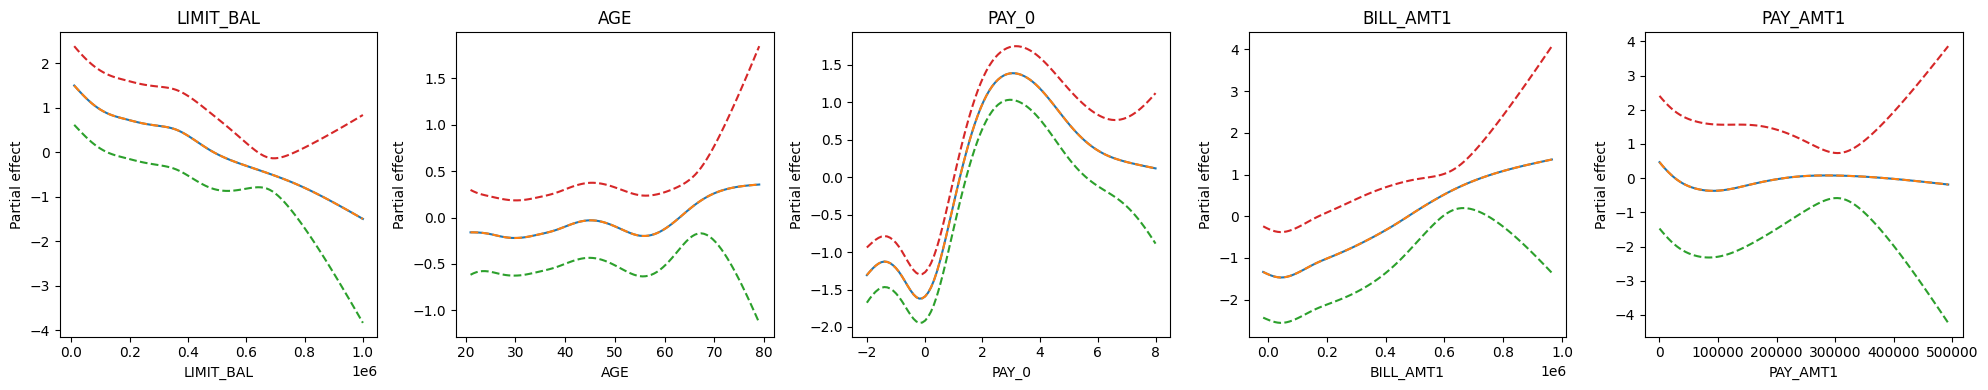

In [31]:
# ------------------------------------------------------------
# 4) Plot smooth terms (similar to plot(credit_gam, pages=1))
#    We plot the 5 smooth terms in a single row.
# ------------------------------------------------------------
smooth_features = ["LIMIT_BAL", "AGE", "PAY_0", "BILL_AMT1", "PAY_AMT1"]
smooth_term_ids = []

# Identify term IDs corresponding to the 5 smooth terms above
for term_id, term in enumerate(credit_gam.terms):
    if getattr(term, "isintercept", False):
        continue
    if hasattr(term, "spline_order"):  # smooth term
        feat_name = X_cols[term.feature]
        if feat_name in smooth_features:
            smooth_term_ids.append((term_id, feat_name))

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, (term_id, feat_name) in zip(axes, smooth_term_ids):
    XX = credit_gam.generate_X_grid(term=term_id)
    pdep = credit_gam.partial_dependence(term=term_id, X=XX)
    ci = credit_gam.partial_dependence(term=term_id, X=XX, width=0.95)

    x = XX[:, col_idx[feat_name]]
    ax.plot(x, pdep)
    ax.plot(x, ci[0], linestyle="--")
    ax.plot(x, ci[1], linestyle="--")
    ax.set_title(feat_name)
    ax.set_xlabel(feat_name)
    ax.set_ylabel("Partial effect")

plt.tight_layout()
plt.show()


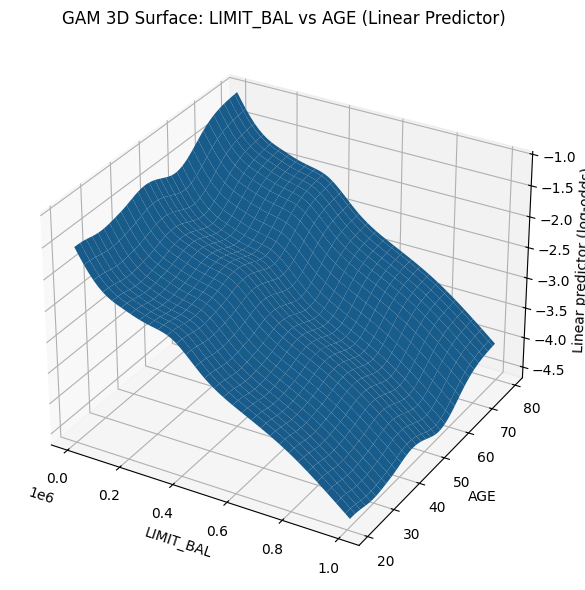

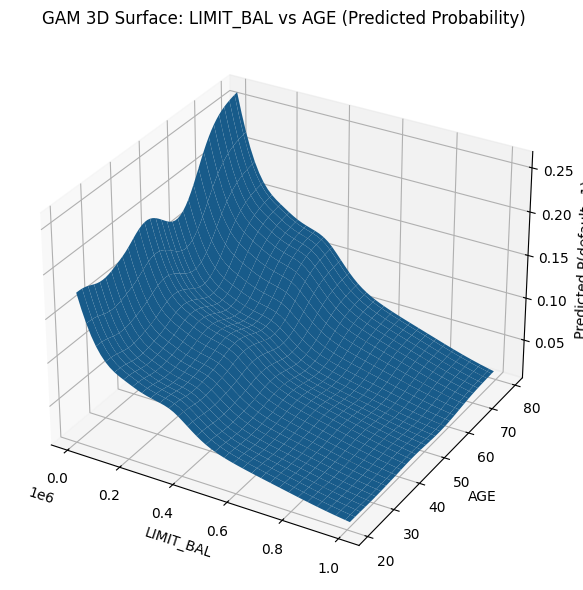

In [32]:
# ============================================================
# 3D-style visualization analogue to mgcv::vis.gam(view=c("LIMIT_BAL","AGE"))
# Goal: visualize the nonlinear relationship between two variables and the
#       GAM linear predictor (log-odds) in a 3D surface plot.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)

# Assumes you already have:
#   credit_gam : fitted pyGAM LogisticGAM
#   X_train    : training DataFrame
#   X_cols     : list of model columns in order
#   col_idx    : dict mapping column name -> column index

# ---- build a grid over LIMIT_BAL and AGE ----
lim_grid = np.linspace(X_train["LIMIT_BAL"].min(), X_train["LIMIT_BAL"].max(), 60)
age_grid = np.linspace(X_train["AGE"].min(), X_train["AGE"].max(), 60)
LIM, AGE = np.meshgrid(lim_grid, age_grid)

# ---- hold other predictors fixed (medians for numeric; mode for factor codes) ----
base = X_train.median(numeric_only=True).to_dict()
for cc in ["SEX_code", "EDUCATION_code", "MARRIAGE_code"]:
    base[cc] = int(X_train[cc].mode().iloc[0])

# ---- assemble the full design matrix over the grid ----
X_grid = np.zeros((LIM.size, len(X_cols)))
for j, name in enumerate(X_cols):
    X_grid[:, j] = base[name]

X_grid[:, col_idx["LIMIT_BAL"]] = LIM.ravel()
X_grid[:, col_idx["AGE"]] = AGE.ravel()

# ---- compute the linear predictor (log-odds) on the grid ----
# This is the closest match to what vis.gam shows by default (linear predictor).
lp = credit_gam._linear_predictor(X_grid).reshape(LIM.shape)

# ============================================================
# (A) 3D Surface Plot (like vis.gam 3D view)
# ============================================================
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(LIM, AGE, lp, linewidth=0, antialiased=True)

ax.set_xlabel("LIMIT_BAL")
ax.set_ylabel("AGE")
ax.set_zlabel("Linear predictor (log-odds)")
ax.set_title("GAM 3D Surface: LIMIT_BAL vs AGE (Linear Predictor)")
plt.tight_layout()
plt.show()

# ============================================================
# (Optional) Also show probability surface (sigmoid(lp))
# ============================================================
prob = 1 / (1 + np.exp(-lp))

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(LIM, AGE, prob, linewidth=0, antialiased=True)

ax.set_xlabel("LIMIT_BAL")
ax.set_ylabel("AGE")
ax.set_zlabel("Predicted P(default=1)")
ax.set_title("GAM 3D Surface: LIMIT_BAL vs AGE (Predicted Probability)")
plt.tight_layout()
plt.show()


In [33]:
# ------------------------------------------------------------
# 1.2.1 In-sample fit performance (pcut = 1/6)
# ------------------------------------------------------------
pcut = 1/6

prob_in = credit_gam.predict_proba(X_train.to_numpy())
pred_in = (prob_in >= pcut).astype(int)

cm_in = confusion_matrix(y_train, pred_in, labels=[0, 1])
cm_in_df = pd.DataFrame(cm_in, index=["Observed 0", "Observed 1"], columns=["Pred 0", "Pred 1"])
cm_in_df


,Pred 0,Pred 1
Observed 0,5214,2364
Observed 1,652,1490


In [34]:
# Asymmetric cost function (5:1), matching your R function
def credit_cost(y_true, y_pred, weight1=5, weight0=1):
    pcut_local = weight0 / (weight0 + weight1)  # 1/6
    c1 = (y_true == 1) & (y_pred < pcut_local)  # actual 1 predicted 0
    c0 = (y_true == 0) & (y_pred > pcut_local)  # actual 0 predicted 1
    return np.mean(weight1 * c1 + weight0 * c0)

cost_in = credit_cost(y_train.to_numpy(), pred_in)
print(f"Asymmetric cost (train): {cost_in:.7f}")


Asymmetric cost (train): 0.5786008


In [35]:
# AIC / BIC / mean residual deviance-like quantity
# - AIC is typically available in statistics_
# - BIC is computed from log-likelihood and edof (if available)
aic = credit_gam.statistics_.get("AIC", np.nan)
loglik = (credit_gam.statistics_.get("loglikelihood", None)
          or credit_gam.statistics_.get("loglikelihood_", None)
          or credit_gam.statistics_.get("loglik", None))
k = (credit_gam.statistics_.get("edof", None)
     or credit_gam.statistics_.get("n_parameters", None)
     or credit_gam.statistics_.get("n_params", None))

n = X_train.shape[0]
bic = (-2 * loglik + k * np.log(n)) if (loglik is not None and k is not None) else np.nan

# "Deviance" analogue: negative log-likelihood * 2 (for binomial), if available
deviance = credit_gam.statistics_.get("deviance", np.nan)

print(f"AIC (train): {aic:.5f}" if np.isfinite(aic) else "AIC (train): (not available)")
print(f"BIC (train): {bic:.5f}" if np.isfinite(bic) else "BIC (train): (could not compute)")
print(f"Deviance (train): {deviance:.5f}" if np.isfinite(deviance) else "Deviance (train): (not available)")


AIC (train): 8557.76424
BIC (train): 8771.48469
Deviance (train): 8498.24817


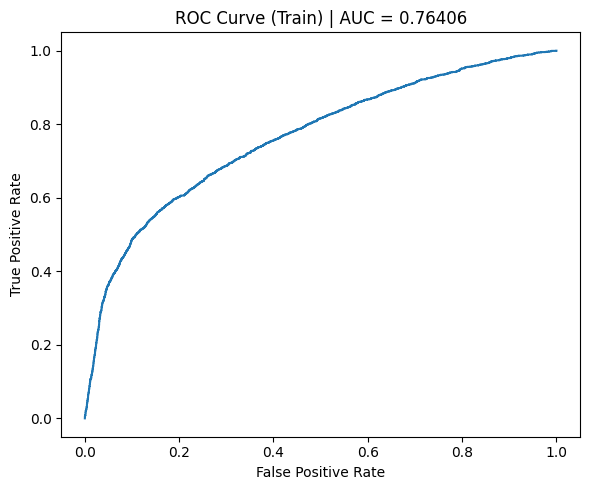

AUC (train): 0.7640628


In [36]:
# ROC + AUC (in-sample)
fpr_in, tpr_in, _ = roc_curve(y_train, prob_in)
auc_in = roc_auc_score(y_train, prob_in)

plt.figure(figsize=(6, 5))
plt.plot(fpr_in, tpr_in)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Train) | AUC = {auc_in:.5f}")
plt.tight_layout()
plt.show()

print(f"AUC (train): {auc_in:.7f}")


In [37]:
# ------------------------------------------------------------
# 1.2.2 Out-of-sample fit performance (pcut = 1/6)
# ------------------------------------------------------------
prob_out = credit_gam.predict_proba(X_test.to_numpy())
pred_out = (prob_out >= pcut).astype(int)

cm_out = confusion_matrix(y_test, pred_out, labels=[0, 1])
cm_out_df = pd.DataFrame(cm_out, index=["Observed 0", "Observed 1"], columns=["Pred 0", "Pred 1"])
cm_out_df


,Pred 0,Pred 1
Observed 0,570,272
Observed 1,80,158


In [38]:
cost_out = credit_cost(y_test.to_numpy(), pred_out)
print(f"Asymmetric cost (test): {cost_out:.7f}")


Asymmetric cost (test): 0.6222222


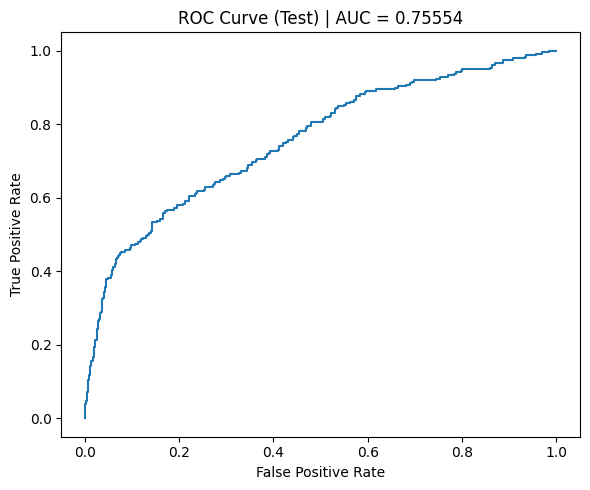

AUC (test): 0.7555390


In [48]:
# ROC + AUC (out-of-sample)
fpr_out, tpr_out, _ = roc_curve(y_test, prob_out)
auc_out = roc_auc_score(y_test, prob_out)

plt.figure(figsize=(6, 5))
plt.plot(fpr_out, tpr_out)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Test) | AUC = {auc_out:.5f}")
plt.tight_layout()
plt.show()

print(f"AUC (test): {auc_out:.7f}")


## 1.3 GAM Using the “Motorcycle” Dataset

Finally, we apply a **GAM** for **univariate smoothing** on the **Motorcycle (mcycle)** dataset.  
Here, we model **acceleration** as a smooth function of **time after impact**, which allows the fitted curve to capture nonlinear patterns in the data.


In [24]:
# ============================================================
# 1.3 GAM using the “Motorcycle” (mcycle) dataset (Google Colab / Python)
# R (mgcv) equivalent:
#   s_gam <- gam(Y ~ s(X), data=mcycle)     # Gaussian GAM with one smooth term
#   summary(s_gam)
#   plot(s_gam, residuals=TRUE)
#
# Python approach (pyGAM):
#   - Load mcycle from statsmodels
#   - Fit LinearGAM with one smooth term: accel ~ s(times)
#   - Print model summary
#   - Plot fitted smooth with residuals overlay (R-like)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

import importlib
if importlib.util.find_spec("pygam") is None:
    !pip -q install pygam

from pygam import LinearGAM, s


In [25]:
# ------------------------------------------------------------
# 0) Load mcycle dataset
# ------------------------------------------------------------
mcycle = sm.datasets.get_rdataset("mcycle", "MASS").data

# Rename variables for ease of use (match your R notation)
X = mcycle["times"].to_numpy()
Y = mcycle["accel"].to_numpy()

print(mcycle.info())
display(mcycle.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   times   133 non-null    float64
 1   accel   133 non-null    float64
dtypes: float64(2)
memory usage: 2.2 KB
None


,times,accel
count,133.000000,133.000000
mean,25.178947,-25.545865
std,13.132063,48.322050
min,2.400000,-134.000000
25%,15.600000,-54.900000
50%,23.400000,-13.300000
75%,34.800000,0.000000
max,57.600000,75.000000


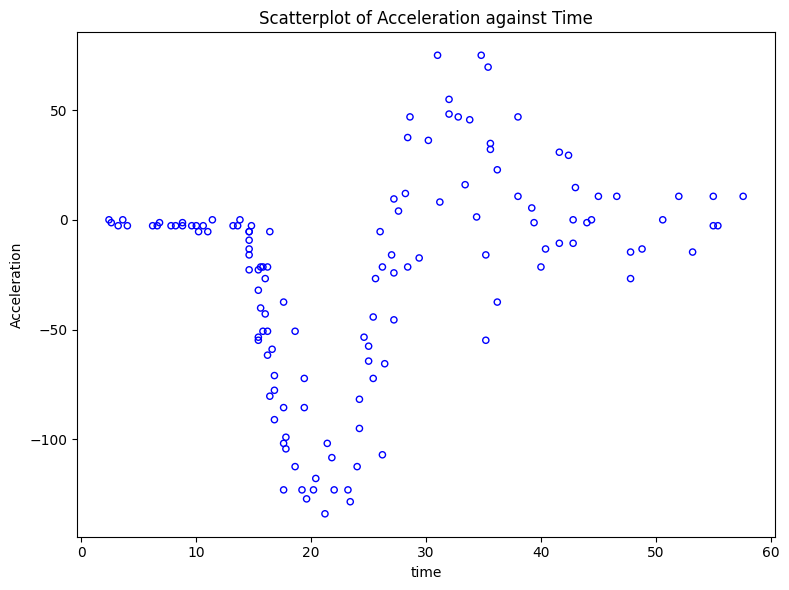

In [26]:
# ------------------------------------------------------------
# 1) Scatterplot: Acceleration vs Time
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, marker="o", facecolors="none", edgecolors="b", s=20)
plt.xlabel("time")
plt.ylabel("Acceleration")
plt.title("Scatterplot of Acceleration against Time")
plt.tight_layout()
plt.show()


In [27]:
# ------------------------------------------------------------
# 2) Fit GAM: Y ~ s(X)  (Gaussian / identity link)
# ------------------------------------------------------------
# pyGAM expects a 2D feature matrix
X_mat = X.reshape(-1, 1)

s_gam = LinearGAM(s(0)).gridsearch(X_mat, Y)

print(s_gam.summary())


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.8135
Link Function:                     IdentityLink Log Likelihood:                                  -597.7641
Number of Samples:                          133 AIC:                                             1221.1551
                                                AICc:                                            1224.1252
                                                GCV:                                              609.3811
                                                Scale:                                              22.645
                                                Pseudo R-Squared:                                   0.7984
Feature Function                  Lam

/tmp/ipython-input-812610192.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(s_gam.summary())


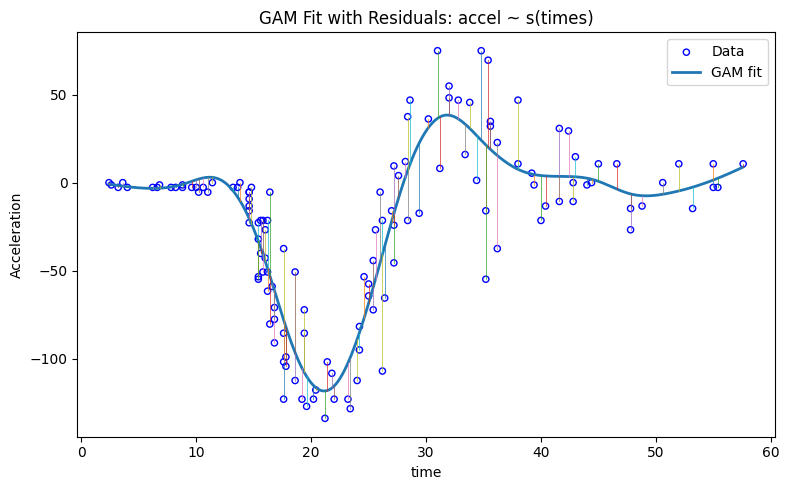

In [28]:
# ------------------------------------------------------------
# 3) Plot the fitted smooth + residuals (R-like)
#    R: plot(s_gam, residuals=TRUE, pch=1)
# ------------------------------------------------------------
# Sort X for a smooth fitted curve
order = np.argsort(X)
X_sorted = X[order]
Y_sorted = Y[order]

X_grid = np.linspace(X_sorted.min(), X_sorted.max(), 300).reshape(-1, 1)
y_fit = s_gam.predict(X_grid)

# Residuals at observed X
y_pred_obs = s_gam.predict(X_mat)
resid = Y - y_pred_obs

plt.figure(figsize=(8, 5))
plt.scatter(X_sorted, Y_sorted, marker="o", facecolors="none", edgecolors="b", s=20, label="Data")
plt.plot(X_grid.ravel(), y_fit, linewidth=2, label="GAM fit")

# Overlay residuals as vertical segments (like residuals=TRUE)
for xi, yi, ri in zip(X, Y, resid):
    plt.plot([xi, xi], [yi, yi - ri], linewidth=0.5)

plt.xlabel("time")
plt.ylabel("Acceleration")
plt.title("GAM Fit with Residuals: accel ~ s(times)")
plt.legend()
plt.tight_layout()
plt.show()


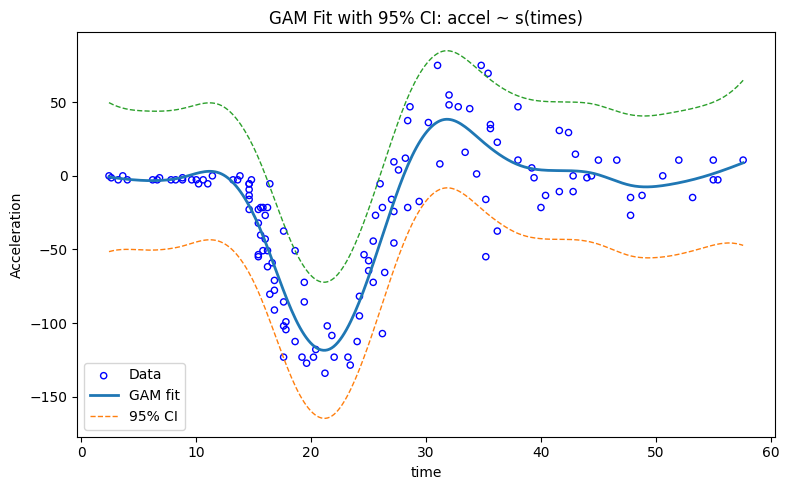

In [29]:
# ------------------------------------------------------------
# (Optional) Also show the 95% confidence band for the smooth
# ------------------------------------------------------------
conf = s_gam.prediction_intervals(X_grid, width=0.95)

plt.figure(figsize=(8, 5))
plt.scatter(X_sorted, Y_sorted, marker="o", facecolors="none", edgecolors="b", s=20, label="Data")
plt.plot(X_grid.ravel(), y_fit, linewidth=2, label="GAM fit")
plt.plot(X_grid.ravel(), conf[:, 0], linestyle="--", linewidth=1, label="95% CI")
plt.plot(X_grid.ravel(), conf[:, 1], linestyle="--", linewidth=1)

plt.xlabel("time")
plt.ylabel("Acceleration")
plt.title("GAM Fit with 95% CI: accel ~ s(times)")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
%%shell
jupyter nbconvert --to html ///content/8_B_Generalized_Additive_Model.ipynb

[NbConvertApp] Converting notebook ///content/8_B_Generalized_Additive_Model.ipynb to html
[NbConvertApp] Writing 392628 bytes to /content/8_B_Generalized_Additive_Model.html
